In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
settings = "mean_absolute"

## Dataframe

In [3]:
df = pd.read_csv(
    "~/ceph/lola/results/rayleigh_benard/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "relative",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "rayleigh",
        "prandtl",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

if "relative" in settings:
    df = df[df["relative"]]
elif "absolute" in settings:
    df = df[~df["relative"]]

df = df[df["time"] > 0]
df = df[df["start"] == 32]
df = df[df["compression"] != 128]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3],
        "std_global": [0.25, 0.15, 0.20, 0.20],
    })
)


def horizon(t):
    if t < 20:
        return "01:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:160"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df["method"] = df["method"].replace("surrogate", "neural solver")
df.loc[df["method"] == "neural solver", "spread_skill"] = 0.0

In [4]:
def aggregate(x):
    if "mean" in settings:
        return np.mean(x)
    elif "median" in settings:
        return np.median(x)

## Plots

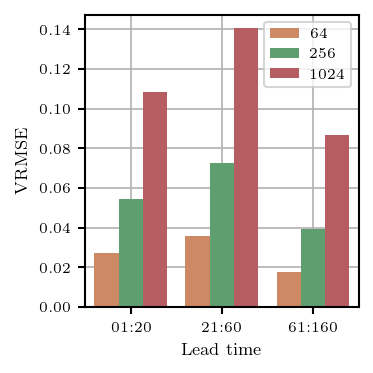

In [5]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(2.4, 2.4))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=aggregate,
    errorbar=None,
    palette=sb.color_palette("deep", 4)[1:],
)

ax.grid()
ax.get_legend().set_title(None)

ax.set_xlabel("Lead time")
ax.set_ylabel("VRMSE")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / f"rb_ae_{settings}.pdf", dpi=300, transparent=True)

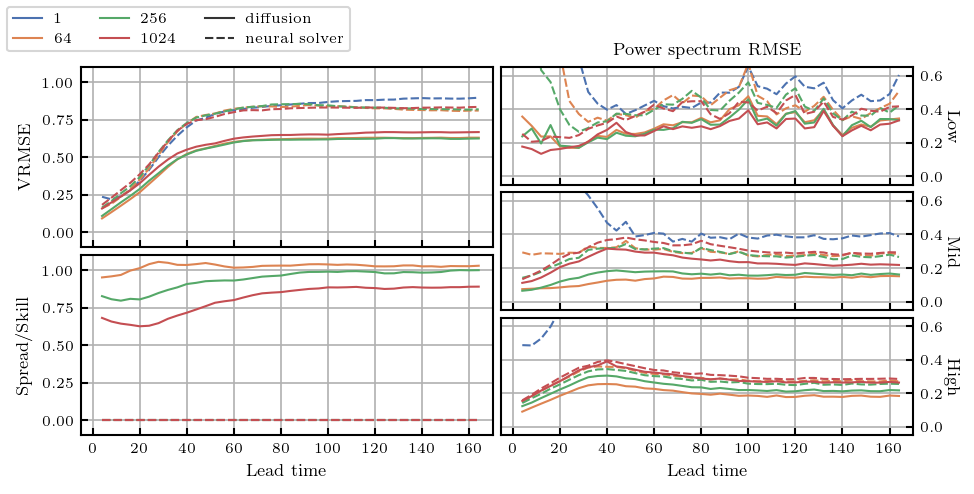

In [6]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 4),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 170)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 4),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 170)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=3)

plt.savefig(outdir / f"rb_mosaic_{settings}.pdf", dpi=300, transparent=True)

## Tables

In [7]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                    01:20  21:60 61:160
method        compression                     
autoencoder   64           0.027  0.036  0.018
              256          0.054  0.072  0.039
              1024         0.108  0.140  0.087
diffusion     64           0.157  0.469  0.625
              256          0.177  0.474  0.621
              1024         0.219  0.507  0.657
neural solver 1            0.245  0.629  0.870
              64           0.219  0.645  0.828
              256          0.235  0.651  0.834
              1024         0.256  0.644  0.827

In [8]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                01:20  21:60 61:160
method        context                     
diffusion     1        0.186  0.486  0.635
              2        0.184  0.481  0.637
              3        0.182  0.482  0.630
neural solver 1        0.231  0.625  0.818
              2        0.235  0.640  0.826
              3        0.244  0.675  0.844

In [9]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                        01:20  21:60 61:160      01:20  21:60 61:160   
method        compression                                                     
autoencoder   64               0.011  0.002  0.001      0.010  0.015  0.010   
              256              0.030  0.006  0.004      0.049  0.111  0.069   
              1024             0.092  0.028  0.018      0.121  0.254  0.196   
diffusion     64               0.283  0.225  0.339      0.078  0.113  0.144   
              256              0.256  0.218  0.330      0.079  0.163  0.164   
              1024             0.158  0.232  0.308      0.137  0.276  0.236   
neural solver 1                4.143  0.661  0.491      1.147  0.565  0.387   
              64               1.873  0.404  0.441      0.286  0.315  0.286   
              256              1.233  0.338  0.429      0.170  0.297  0.281   
              1024             0.227  0.305  0.404      0.174  0.336  0.309   

                          rmse_p_high                
horizon                         01:20  21:60 61:160  
method        compression                            
autoencoder   64                0.099  0.194  0.139  
              256               0.150  0.268  0.207  
              1024              0.197  0.340  0.274  
diffusion     64                0.126  0.234  0.190  
              256               0.159  0.279  0.224  
              1024              0.199  0.340  0.277  
neural solver 1                 0.523  1.029  0.824  
              64                0.198  0.333  0.281  
              256               0.184  0.315  0.264  
              1024              0.209  0.358  0.298

## Images

In [10]:
path = Path("~/ceph/lola/videos/rayleigh_benard")
path = path.expanduser()

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 0
frames = np.array([0, 2, 4, 8, 16, 32])

for run, method, compression in runs.values:
    files = (path / run).glob("*032*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, :]
        x_hat = x_hat[:, field, frames, ::2, :]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"rb_{i}_{method}_{compression:04d}_{j}.png")